In [1]:
import os, json, re
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    set_seed
)

os.makedirs("figures", exist_ok=True)
set_seed(42)


In [2]:
from google.colab import files
uploaded = files.upload()
csv_name = next(iter(uploaded))
df_raw = pd.read_csv(csv_name)

print(df_raw.columns)
df_raw.head()


Saving SEntFiN.csv to SEntFiN.csv
Index(['S No.', 'Title', 'Decisions', 'Words'], dtype='object')


,S No.,Title,Decisions,Words
0,1,SpiceJet to issue 6.4 crore warrants to promoters,"{""SpiceJet"": ""neutral""}",8
1,2,MMTC Q2 net loss at Rs 10.4 crore,"{""MMTC"": ""neutral""}",8
2,3,"Mid-cap funds can deliver more, stay put: Experts","{""Mid-cap funds"": ""positive""}",8
3,4,Mid caps now turn into market darlings,"{""Mid caps"": ""positive""}",7
4,5,"Market seeing patience, if not conviction: Pra...","{""Market"": ""neutral""}",8


In [3]:
def parse_decisions(x):
    if pd.isna(x):
        return {}
    if isinstance(x, dict):
        return x
    s = str(x).strip()
    try:
        return json.loads(s)
    except Exception:
        try:
            return json.loads(s.replace("'", '"'))
        except Exception:
            return {}

def norm_sent(lbl):
    lbl = str(lbl).strip().lower()
    if lbl in ["positive","pos","bullish","up","buy"]:
        return "positive"
    if lbl in ["negative","neg","bearish","down","sell"]:
        return "negative"
    return "neutral"

rows = []
for _, r in df_raw.iterrows():
    title = str(r.get("Title", "")).strip()
    dec = parse_decisions(r.get("Decisions", None))
    if not title or not dec:
        continue
    for ent, sent in dec.items():
        rows.append({
            "text": title,
            "entity": str(ent).strip(),
            "label_str": norm_sent(sent),
        })

df = pd.DataFrame(rows)
print("Expanded rows:", len(df))
print(df["label_str"].value_counts())
df.head()


Expanded rows: 14409
label_str
neutral     5515
positive    5075
negative    3819
Name: count, dtype: int64


,text,entity,label_str
0,SpiceJet to issue 6.4 crore warrants to promoters,SpiceJet,neutral
1,MMTC Q2 net loss at Rs 10.4 crore,MMTC,neutral
2,"Mid-cap funds can deliver more, stay put: Experts",Mid-cap funds,positive
3,Mid caps now turn into market darlings,Mid caps,positive
4,"Market seeing patience, if not conviction: Pra...",Market,neutral


In [4]:
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v:k for k,v in label2id.items()}

df["label"] = df["label_str"].map(label2id).astype(int)


In [5]:
X = df["text"].tolist()
y = df["label"].tolist()

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp
)

print("train/val/test:", len(X_train), len(X_val), len(X_test))


train/val/test: 11527 1441 1441


In [6]:
MODEL_NAME = "mrm8488/deberta-v3-ft-financial-news-sentiment-analysis"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_batch(texts, max_len=128):
    return tokenizer(texts, truncation=True, max_length=max_len)

train_enc = tokenize_batch(X_train, max_len=128)
val_enc   = tokenize_batch(X_val,   max_len=128)
test_enc  = tokenize_batch(X_test,  max_len=128)

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_ds = SimpleDataset(train_enc, y_train)
val_ds   = SimpleDataset(val_enc, y_val)
test_ds  = SimpleDataset(test_enc, y_test)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
    }

args = TrainingArguments(
    output_dir="deberta_finance_sentiment_out",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    report_to="none",
    load_best_model_at_end=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/568M [00:00<?, ?B/s]

/tmp/ipython-input-2568900144.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss
50,0.826100
100,0.744100
150,0.608600
200,0.672900
250,0.649900
300,0.620200
350,0.627800
400,0.574000
450,0.612500
500,0.598000


TrainOutput(global_step=4323, training_loss=0.4443273445039388, metrics={'train_runtime': 305.3229, 'train_samples_per_second': 113.26, 'train_steps_per_second': 14.159, 'total_flos': 189133969791294.0, 'train_loss': 0.4443273445039388, 'epoch': 3.0})

In [9]:
val_metrics = trainer.evaluate(val_ds)
print("VAL:", val_metrics)

pred = trainer.predict(test_ds)
test_logits = pred.predictions
test_labels = pred.label_ids
test_preds = np.argmax(test_logits, axis=-1)

test_acc = accuracy_score(test_labels, test_preds)
test_f1  = f1_score(test_labels, test_preds, average="macro")

print("TEST accuracy:", test_acc)
print("TEST macro_f1:", test_f1)
print("Confusion matrix:\n", confusion_matrix(test_labels, test_preds))
print(classification_report(test_labels, test_preds, target_names=[id2label[i] for i in range(3)]))

results = pd.DataFrame([
    {"model": MODEL_NAME, "split":"val",  "accuracy": float(val_metrics.get("eval_accuracy", np.nan)), "macro_f1": float(val_metrics.get("eval_macro_f1", np.nan))},
    {"model": MODEL_NAME, "split":"test", "accuracy": float(test_acc),                                  "macro_f1": float(test_f1)},
])
results.to_csv("deberta_finance_sentiment_results.csv", index=False)
results


VAL: {'eval_loss': 0.5913699865341187, 'eval_accuracy': 0.8001387925052047, 'eval_macro_f1': 0.8014903342022865, 'eval_runtime': 1.4552, 'eval_samples_per_second': 990.259, 'eval_steps_per_second': 62.535, 'epoch': 3.0}
TEST accuracy: 0.8216516308119362
TEST macro_f1: 0.8227168755950834
Confusion matrix:
 [[334  35  13]
 [ 57 420  75]
 [ 29  48 430]]
              precision    recall  f1-score   support

    negative       0.80      0.87      0.83       382
     neutral       0.83      0.76      0.80       552
    positive       0.83      0.85      0.84       507

    accuracy                           0.82      1441
   macro avg       0.82      0.83      0.82      1441
weighted avg       0.82      0.82      0.82      1441



,model,split,accuracy,macro_f1
0,mrm8488/deberta-v3-ft-financial-news-sentiment...,val,0.800139,0.801490
1,mrm8488/deberta-v3-ft-financial-news-sentiment...,test,0.821652,0.822717


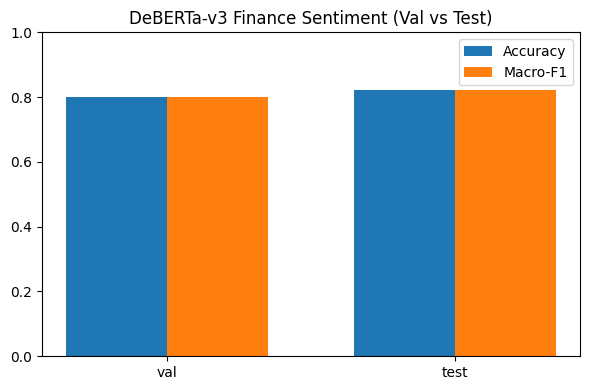

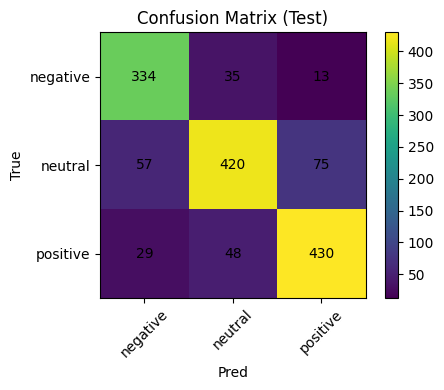

In [10]:
labels = ["val", "test"]
accs = [float(val_metrics.get("eval_accuracy", np.nan)), float(test_acc)]
f1s  = [float(val_metrics.get("eval_macro_f1", np.nan)), float(test_f1)]

x = np.arange(len(labels))
w = 0.35
plt.figure(figsize=(6,4))
plt.bar(x - w/2, accs, w, label="Accuracy")
plt.bar(x + w/2, f1s,  w, label="Macro-F1")
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.title("DeBERTa-v3 Finance Sentiment (Val vs Test)")
plt.legend()
plt.tight_layout()
plt.savefig("figures/deberta_finance_val_test.png", dpi=200)
plt.show()

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
ticks = np.arange(3)
plt.xticks(ticks, [id2label[i] for i in range(3)], rotation=45)
plt.yticks(ticks, [id2label[i] for i in range(3)])
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.ylabel("True")
plt.xlabel("Pred")
plt.tight_layout()
plt.savefig("figures/deberta_finance_confusion.png", dpi=200)
plt.show()


In [11]:
trainer.save_model("deberta_finance_sentiment_model")
tokenizer.save_pretrained("deberta_finance_sentiment_model")
print("Saved to deberta_finance_sentiment_model/")


Saved to deberta_finance_sentiment_model/
